# Geostatistics Demonstration - SGS/SIS/MPS

### Honggeun Jo, Assistant Professor, Inha University (Korea)
This demo showcases an implementation of basic geostatistical modelling, including sequential Gaussian simulation (**SGS**), sequential indicator simulation (**SIS**), and multi-point statistics (**MPS**). In this demo, we first import 2D well information with various reservoir properties, such as porosity, acoustic impedence, facies, permeability and brittleness. Then we calculate variogram to assess spatial continuity in the reservoir. Finally, with the designed variogram, we run SGS with (1) Python, which will be readily too heave as dimension rises, and (2) GSLIB, programed in Fortran by Dr. Clayton Deuatsch.:

1. Load open packages and import the CSV file (regarding well data) into Python using Pandas.
2. Visualize the well data.
3. Compute variogram.
4. **Implement SGS using Python**
5. **Repeat SGS with GSLIB**
6. **run SIS (for categorical facies) with GSLIB**
7. **run SNESIM with standalone excutable from https://github.com/SCRFpublic/snesim-standalone**

The demo is presented by Honggeun Jo, an Assistant Professor at Inha University (Korea). You can reach out to him through his contacts on [Youtube/whghdrms](https://www.youtube.com/@whghdrms) | [GitHub/whghdrms](https://github.com/whghdrms) |  [GoogleScholar](https://scholar.google.com/citations?user=u0OE5CIAAAAJ&hl=en) | [LinkedIn](https://www.linkedin.com/in/honggeun-jo/)

**Note that this workflow was originally developed by Dr. Pyrcz, and the details can be found from the https://github.com/GeostatsGuy/GeostatsPy **


### 1. Load open packages and import the CSV file

In [1]:
## Import packages that will be used in this demo
import os                                                 # to set current working directory 
import numpy as np                                        # arrays and matrix math
import pandas as pd                                       # DataFrames
import matplotlib.pyplot as plt                           # plotting
import geostatspy.geostats as geostats
import geostatspy.GSLIB as GSLIB
import time

In [5]:
## Change working directory where you have well data
os.chdir("D:/OneDrive - 인하대학교/바탕 화면/인하대학교/300 연구자료/301 Geostats for 3D model/KSMER_GeostatsDemo") 

In [6]:
## Import well datat
df = pd.read_csv("1_sample_data.csv")                       # read a .csv file in as a DataFrame
df_1, df_2 = df[df['Facies']==1].sample(25),df[df['Facies']==0].sample(20),
df = pd.concat([df_1,df_2]).reset_index()
df['NPor'], tvPor, tnsPor = geostats.nscore(df, 'Porosity') # nscore transform for all facies porosity
df.describe()                                               # summary statistics 

,index,X,Y,Z,Facies,Porosity,Perm,AI,NPor
count,45.000000,45.000000,45.000000,45.0,45.000000,45.000000,45.000000,45.000000,4.500000e+01
mean,147.533333,502.777778,507.533333,1000.0,0.555556,0.138916,731.682524,5324.936445,5.895599e-03
std,79.985112,300.731222,302.019235,0.0,0.502519,0.030761,3622.935713,1352.363312,9.840041e-01
min,6.000000,10.000000,9.000000,1000.0,0.000000,0.085409,0.023559,2404.998693,-2.021246e+00
25%,77.000000,240.000000,279.000000,1000.0,0.000000,0.118398,1.221432,4452.573094,-6.571086e-01
50%,158.000000,530.000000,499.000000,1000.0,1.000000,0.138240,5.368073,5574.433666,-1.490050e-08
75%,211.000000,750.000000,760.000000,1000.0,1.000000,0.158505,153.595046,6304.593960,6.571086e-01
max,269.000000,980.000000,994.000000,1000.0,1.000000,0.219892,24182.542970,7911.757046,2.286548e+00


### 2. Visualize the well data.

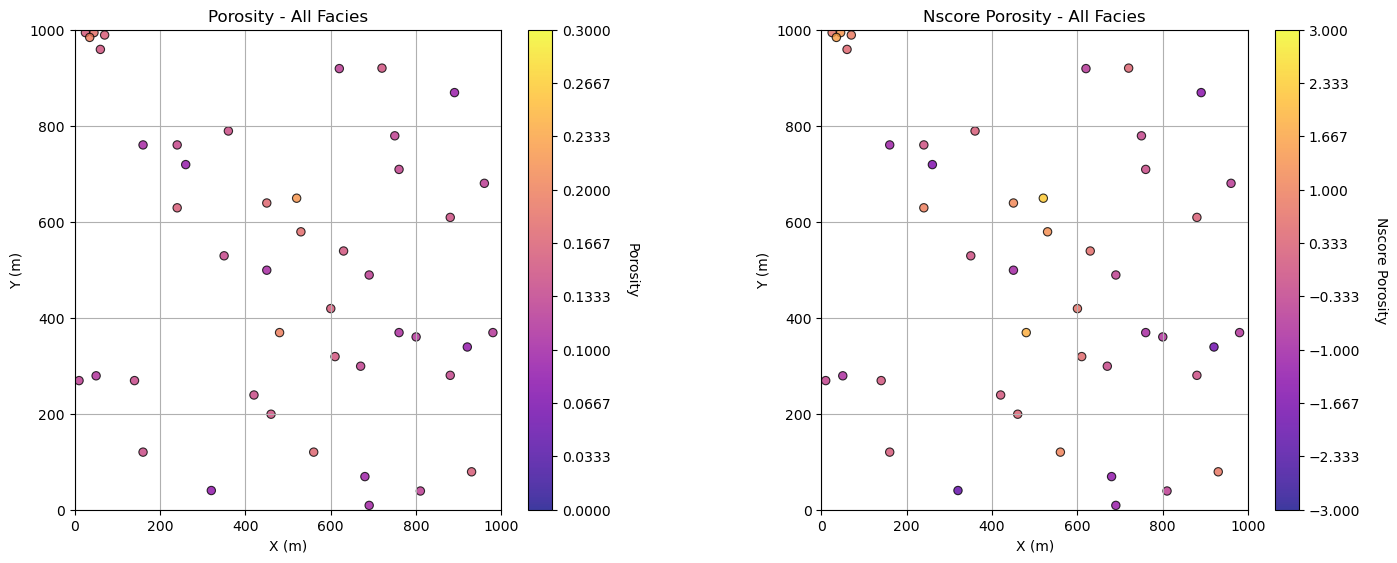

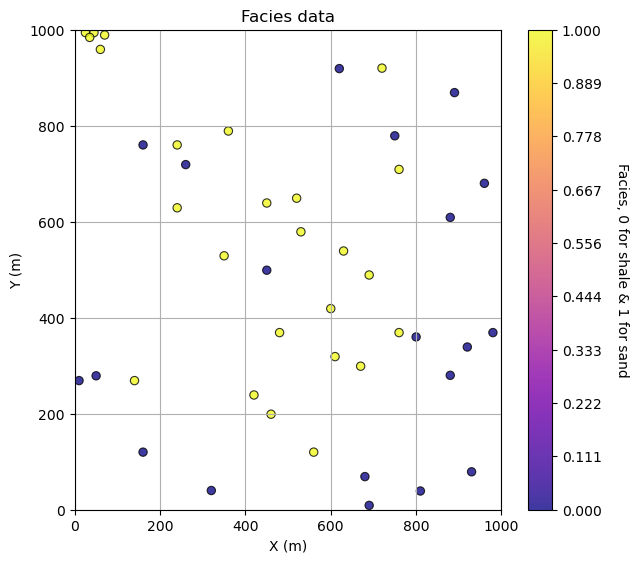

In [7]:
cmap = plt.cm.plasma #color map

## Visualize porosity Map
plt.figure()
plt.subplot(121)
GSLIB.locmap_st(df,'X','Y','Porosity',0,1000,0,1000,0,0.3,'Porosity - All Facies','X (m)','Y (m)','Porosity',cmap)
plt.grid()
plt.subplot(122)
GSLIB.locmap_st(df,'X','Y','NPor',0,1000,0,1000,-3,3,'Nscore Porosity - All Facies','X (m)','Y (m)','Nscore Porosity',cmap)
plt.grid()
plt.subplots_adjust(left=0.0, bottom=0.0, right=2.0, top=1, wspace=0.4, hspace=0.3)
plt.show()

## Visualize facies Map
plt.figure()
plt.subplot(121)
GSLIB.locmap_st(df,'X','Y','Facies',0,1000,0,1000,0,1,'Facies data','X (m)','Y (m)','Facies, 0 for shale & 1 for sand',cmap)
plt.grid()
plt.subplots_adjust(left=0.0, bottom=0.0, right=2.0, top=1, wspace=0.4, hspace=0.3)
plt.show()

### 3. Calulate variogram 

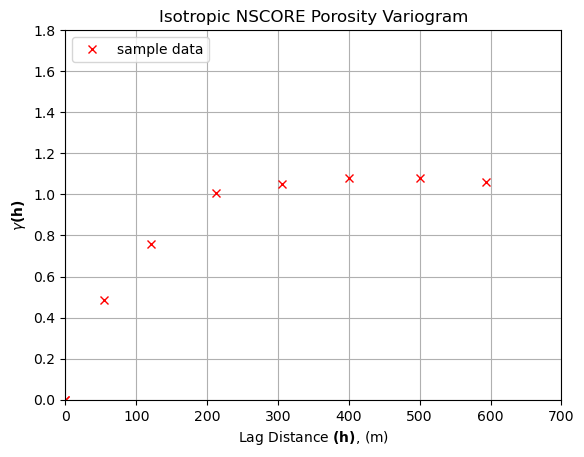

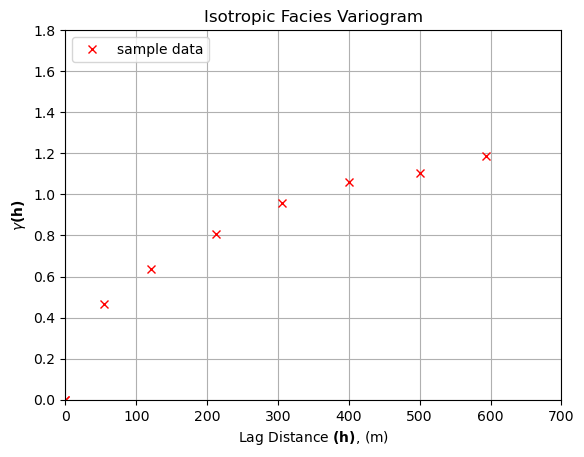

In [8]:
## Calculate Sample Data Isotropic Variograms
## These are variogram parameters, please refer to the reference books
tmin = -9999.; tmax = 9999.; 
lag_dist = 100.0; lag_tol = 100.0; nlag = 7; bandh = 9999.9; azi = 0; atol = 90.0; isill = 1

lag, por_gamma, por_npair = geostats.gamv(df,"X","Y","NPor",tmin,tmax,lag_dist,lag_tol,nlag,azi,atol,bandh,isill)
plt.figure()
plt.plot(lag,por_gamma,'x',color='red',label='sample data')
plt.xlabel(r'Lag Distance $\bf(h)$, (m)')
plt.ylabel(r'$\gamma \bf(h)$')
plt.title('Isotropic NSCORE Porosity Variogram')
plt.xlim([0,700])
plt.ylim([0,1.8])
plt.legend(loc='upper left')
plt.grid(True)

lag, por_gamma, por_npair = geostats.gamv(df,"X","Y","Facies",tmin,tmax,lag_dist,lag_tol,nlag,azi,atol,bandh,isill)
plt.figure()
plt.plot(lag,por_gamma,'x',color='red',label='sample data')
plt.xlabel(r'Lag Distance $\bf(h)$, (m)')
plt.ylabel(r'$\gamma \bf(h)$')
plt.title('Isotropic Facies Variogram')
plt.xlim([0,700])
plt.ylim([0,1.8])
plt.legend(loc='upper left')
plt.grid(True)

 x,y,z offsets = 0.0,10.0


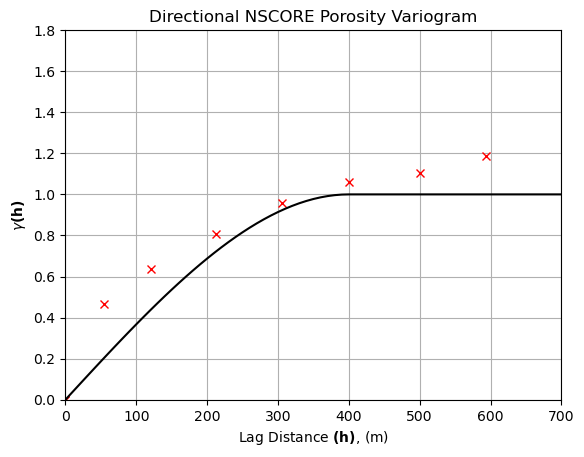

In [11]:
## Fit the above figure to a variogram model
nug = 0.0; # No nugget
nst = 1;   # 1 nest structure variogram model parameters                                       
it1 = 1;   # type 1 = Gaussian, 2 = Spherical, 3 = exponential
cc1 = 1.0; # sill
azi1 = 0;  # No need for isotropic variogram
hmaj1 = 400; hmin1 = 400 # Range

vario = GSLIB.make_variogram(nug,nst,it1,cc1,azi1,hmaj1,hmin1) # make model object
nlag = 70; xlag = 10; azm = 0;                                # project the model in the 0 azimuth (doesn't matter since I assume isotropic)
index45,h45,gam45,cov45,ro45 = geostats.vmodel(nlag,xlag,azm,vario)

plt.plot(lag,por_gamma,'x',color = 'red')
plt.plot(h45,gam45,color = 'black')
plt.xlabel(r'Lag Distance $\bf(h)$, (m)')
plt.ylabel(r'$\gamma \bf(h)$')
plt.title('Directional NSCORE Porosity Variogram')
plt.xlim([0,700])
plt.ylim([0,1.8])
plt.grid()

## 4. Run Sequential Gaussian simulation in Python (slow) 


In [16]:
# %%time

# ## Demonstration of Multiple Realizations - Short Continuity(100)
# nx = 50; ny = 50; #number of cells
# xsiz = 20.0; ysiz = 20.0; #cell size
# xmn = 10.0; ymn = 10.0; # grid origin, location center of lower left cell

# ## basic indicator kriging parameters
# nxdis = 1; nydis = 1   # block kriging discretizations, 1 for point kriging
# ndmin = 0; ndmax = 20; # minimum and maximum data for kriging 
# radius = 400;          # maximum search distance
# ktype = 1;             # kriging type, 0 - simple, 1 - ordinary
# skmean = 0             # desired mean (after Normal score transform, should be zero)
# vario = GSLIB.make_variogram(nug=0.0,nst=1,it1=1,cc1=1.0,azi1=0,hmaj1=300,hmin1=300)
# tmin = -999; tmax = 999  # data trimming limits

# sim = geostats.sgsim(df,'X','Y','Porosity',wcol=-1,scol=-1,tmin=tmin,tmax=tmax,itrans=1,ismooth=0,dftrans=0,tcol=0,twtcol=0,
#             zmin=0.0,zmax=0.3,ltail=1,ltpar=0.0,utail=1,utpar=0.3,nsim=1,
#             nx=nx,xmn=xmn,xsiz=xsiz,ny=ny,ymn=ymn,ysiz=ysiz,seed=73073,
#             ndmin=ndmin,ndmax=ndmax,nodmax=20,mults=0,nmult=2,noct=-1,radius=radius,radius1=1,sang1=0,
#             mxctx=10,mxcty=10,ktype=ktype,colocorr=0.0,sec_map=0,vario=vario)
# xmin = 0.0; xmax = 1000.0; ymin = 0.0; ymax = 1000.0; 

# cmap = plt.cm.plasma #color map
# plt.subplot(131)
# GSLIB.locpix_st(sim,xmin,xmax,ymin,ymax,xsiz,0.05,0.25,df,'X','Y','Porosity','Sequential Gaussian Simulation - Realization 1','X(m)','Y(m)','Porosity',cmap)
# plt.subplots_adjust(left=0.0, bottom=0.0, right=3.0, top=1.2, wspace=0.2, hspace=0.2)
# plt.show()

CPU times: total: 0 ns
Wall time: 0 ns


Please note that 50x50 2D SGS model takes ~13 sec to run, which will be much more if we need (1) 3D model as we need additional dimension in z-direction or (2) multiple realizaions for probabilistic approach (e.g., ensemble based uncertainty assessment, which is more typical method for any reservoir engineering workflow). That's why it is still useful to run SGS in GSLIB (GeoStatistics LIBrary, by Dr. Clayton Deutsche at the University of Alberta) with an assist of geostatspy (works as a wrapper, written by Dr. Michael J. Pyrcz in the university of Texas at Austin). The following cells show how much time can be saved with GSLIB.

## 4. Run sequential Gaussian simulation by GSLIB 


In [17]:
# Wrapper for GSLIB (from Dr. Pyrcz' work)
%load_ext autoreload
%autoreload 2
from geostats_util import create_sgs_model, sgs_realizations, create_sis_model, sis_realizations

from scipy.interpolate import interp1d
tvPor_ = np.append(np.insert(tvPor,0,0.05), 0.3)
tnsPor_ = np.append(np.insert(tnsPor,0,-3), 3)
npor2por = interp1d(tnsPor_,tvPor_, kind='linear',bounds_error=False)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [18]:
## Define Variogram in dictionary format
vario_sgs = { "nug": 0,      # Nugger
              "nst": 1,      # Num. of structure
              "it1": 1,      # Variogram type, 1 = Gaussian, 2 = Spherical, 3 = exponential
              "cc1": 1,      # Sill
              "azi1": 0.0,   # Azimuth of major direction
              "dip1": 0.0,   # No dip
              "hmax1": 300,  # Major range
              "hmed1": 300,  # Minor range 
              "hmin1": 100   # Vertical range
}

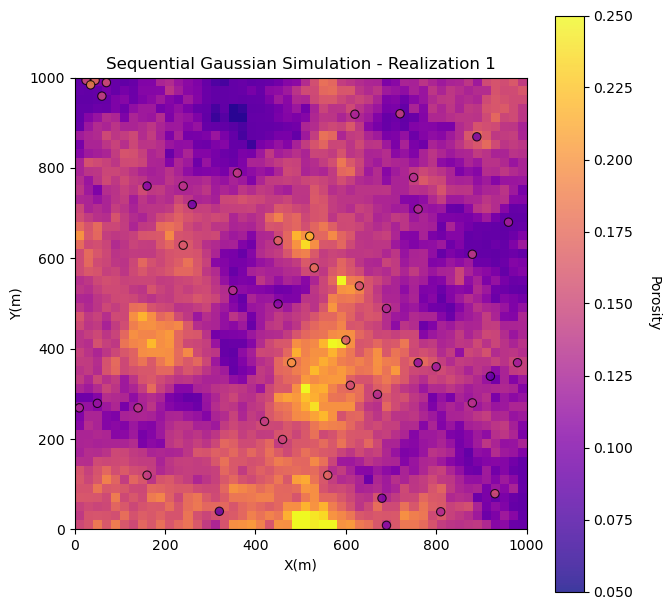

CPU times: total: 312 ms
Wall time: 449 ms


In [21]:
%%time
## Run SGS with GSLIB
# for zmn in np.linspace(950,1050,11):
# Creat Inputs for SGSIM.exe
Num_real = 1
nx,ny,nz = nx,ny,1
xsiz = xsiz; ysiz = ysiz; #cell size
zsiz = 100.0
xmn = xmn; ymn = ymn; zmn = 1000; # grid origin, location center of lower left cell

Input_sgs = create_sgs_model(df, vario_sgs, Val_name = 'NPor',Val_range=[-3,3], Num_real = Num_real, seed=77777, 
                                 grid_dim = [nx,ny,nz], grid_mn=[xmn, ymn, zmn], horizon_grid_size = xsiz, vertical_grid_size = zsiz,

                                 ) 
# Run GSLIB and read output (sgsim.out) 
sgs = sgs_realizations(Input_sgs)
sgs = npor2por(sgs)

cmap = plt.cm.plasma #color map
plt.subplot(131)
xmin,xmax,ymin,ymax,xsiz, = 0,1000,0,1000,20,
GSLIB.locpix_st(sgs[0,::-1,:],0,1000,0,1000,20,0.05,0.25,df,'X','Y','Porosity','Sequential Gaussian Simulation - Realization 1','X(m)','Y(m)','Porosity',cmap)

plt.subplots_adjust(left=0.0, bottom=0.0, right=3.0, top=1.2, wspace=0.2, hspace=0.2)
plt.show()


<timed exec>:17: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.


CPU times: total: 2.36 s
Wall time: 3.44 s


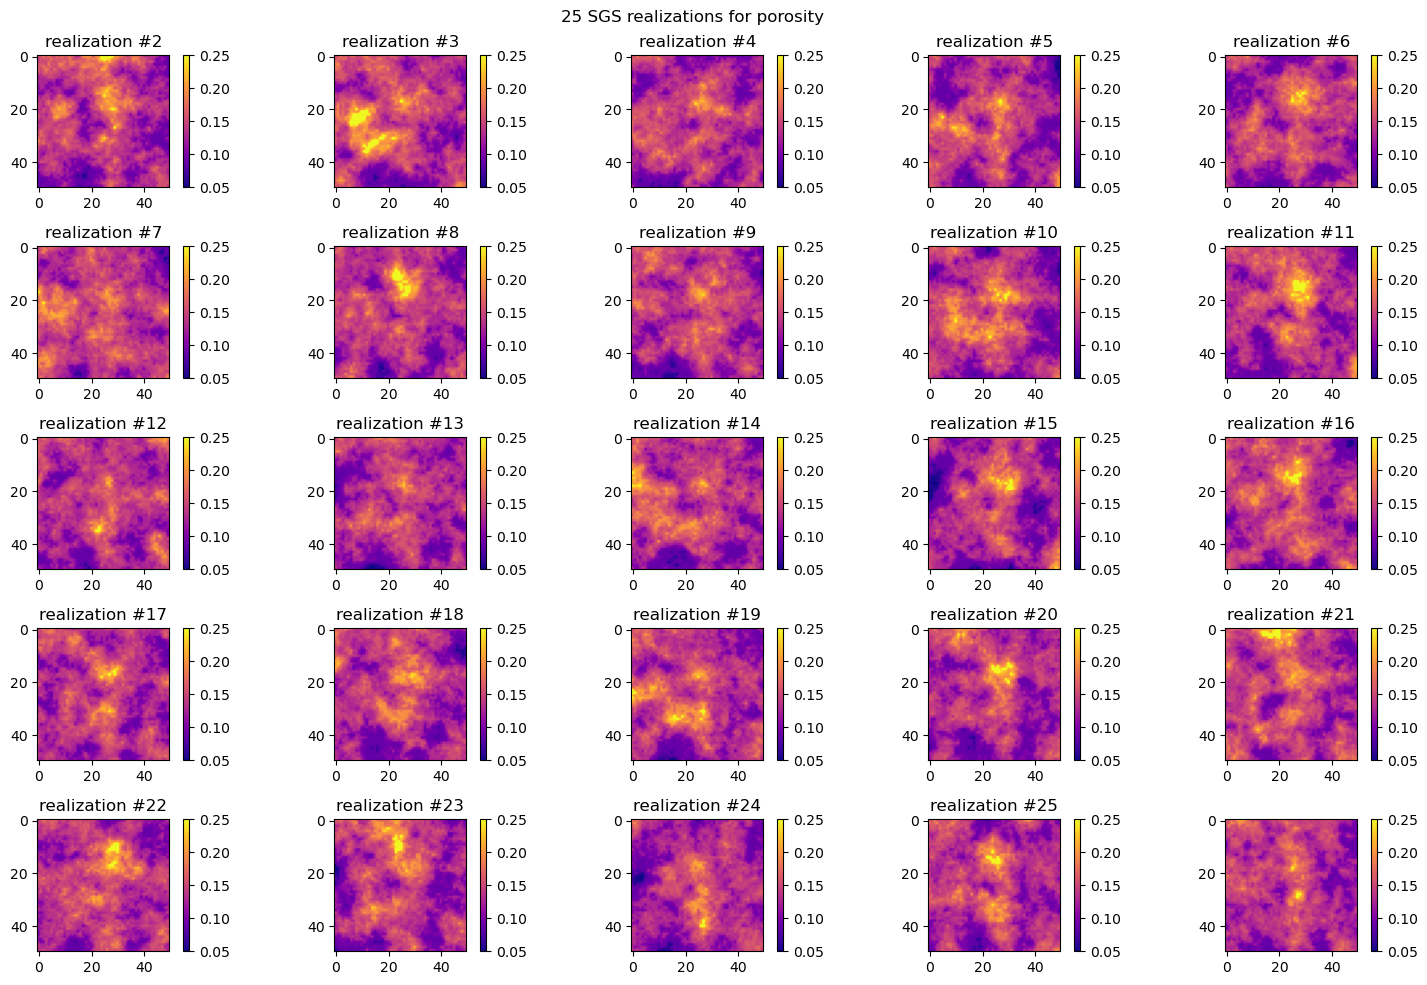

In [22]:
%%time
## Now, let's generate 25 realizations
Num_real = 25

Input_sgs = create_sgs_model(df, vario_sgs, Val_name = 'NPor',Val_range=[-3,3], Num_real = Num_real, seed=77777, 
                                 grid_dim = [nx,ny,nz], grid_mn=[xmn, ymn, zmn], horizon_grid_size = xsiz, vertical_grid_size = zsiz,

                                 ) 
# Run GSLIB and read output (sgsim.out) 
sgs = sgs_realizations(Input_sgs)
sgs = npor2por(sgs)

# visualize realizations
plt.figure(figsize = (15,10))
plt.suptitle('25 SGS realizations for porosity')
for i in range(25):
    plt.title(f'realization #{i+1}')
    plt.subplot(5,5,i+1)
    plt.imshow(sgs[i], cmap = 'plasma', vmin = 0.05, vmax = 0.25)
    plt.colorbar()
plt.tight_layout()

## + Seqeuntial indicator simulation for categorical variables

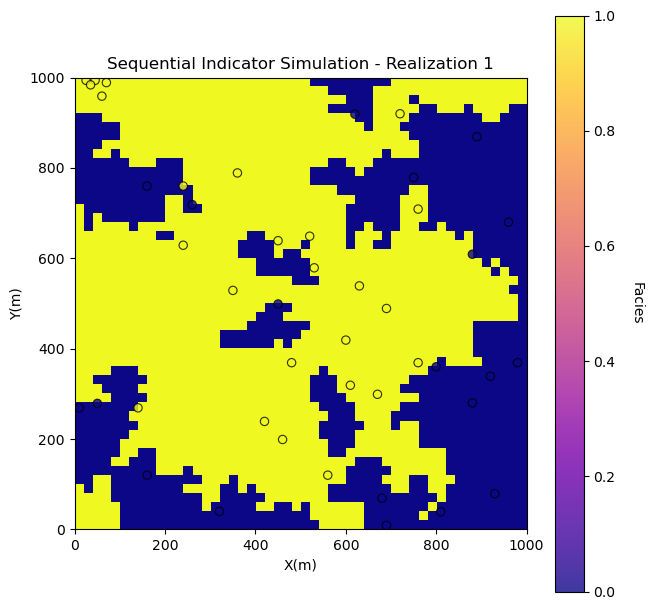

CPU times: total: 609 ms
Wall time: 882 ms


In [23]:
%%time
## Run SIS with GSLIB

# Creat Inputs for SGSIM.exe
Num_real = 1
Input_sis = create_sis_model(df, vario_sgs, Val_name = 'Facies', Num_real = Num_real, seed=77777, 
                                 grid_dim = [nx,ny,nz], grid_mn=[xmn, ymn, zmn], horizon_grid_size = xsiz, vertical_grid_size = zsiz, 
                         ) 
# Run GSLIB and read output (sisim.out) 
sis = sis_realizations(Input_sis)

plt.subplot(131)
GSLIB.locpix_st(sis[0],xmin,xmax,ymin,ymax,xsiz,0.0,1.0,df,'X','Y','Facies','Sequential Indicator Simulation - Realization 1','X(m)','Y(m)','Facies',cmap)
plt.subplots_adjust(left=0.0, bottom=0.0, right=3.0, top=1.2, wspace=0.2, hspace=0.2)
plt.show()

C:\Users\DELL\AppData\Local\Temp\ipykernel_25880\3874811144.py:14: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(5,5,i+1)


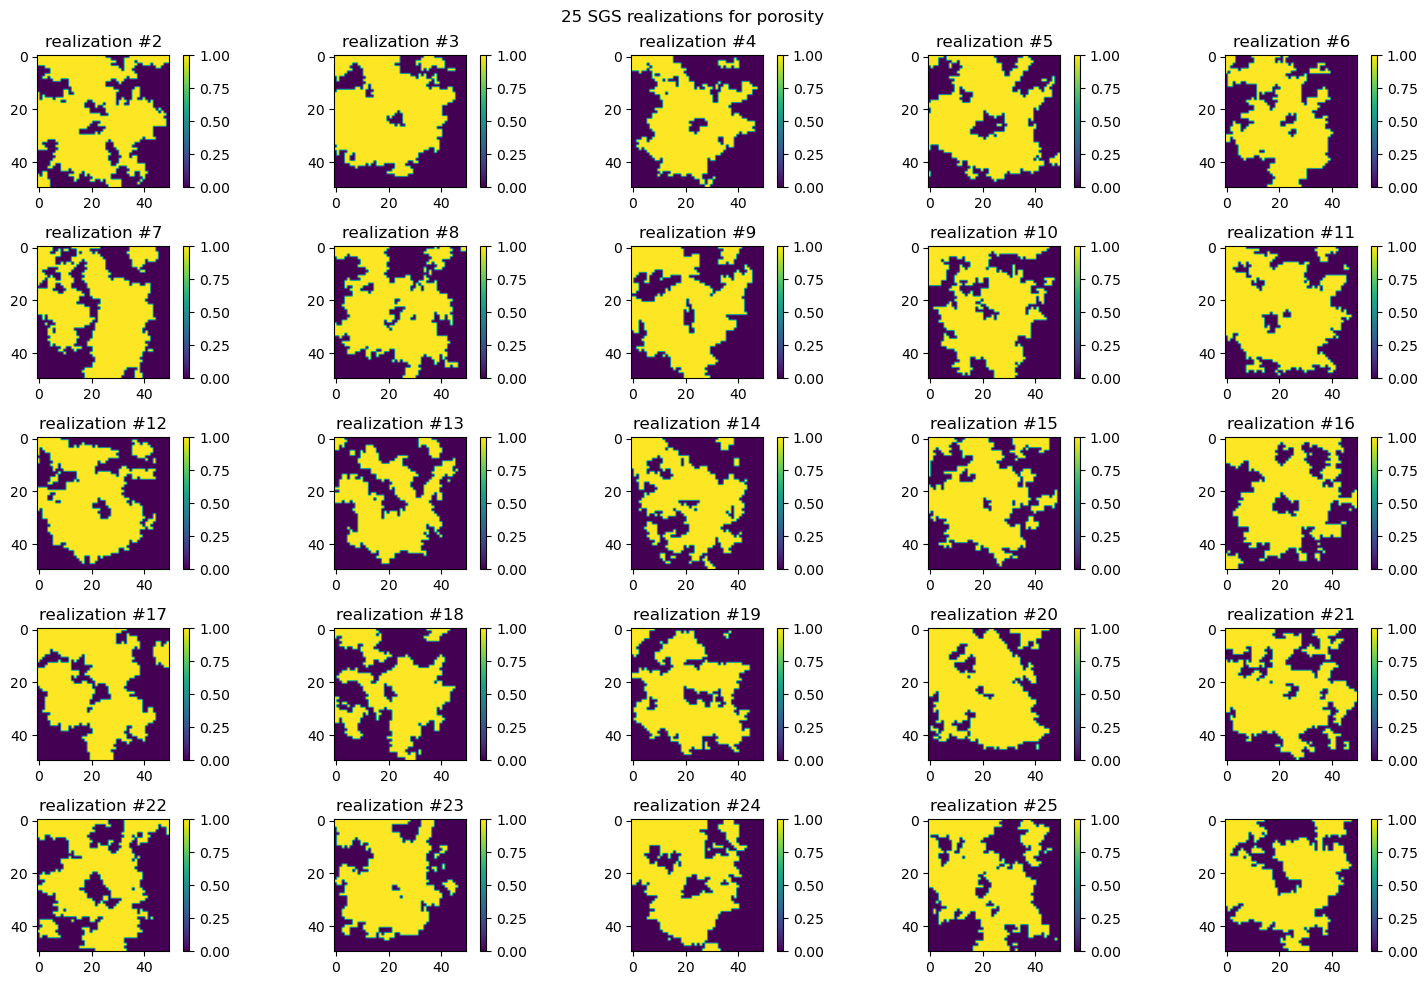

In [24]:
## Now, let's generate 25 realizations
Num_real = 25
Input_sis = create_sis_model(df, vario_sgs, Val_name = 'Facies', Num_real = Num_real, seed=77777, 
                                 grid_dim = [nx,ny,nz],grid_mn=[xmn, ymn, zmn], horizon_grid_size = xsiz, vertical_grid_size = zsiz, 
                                 ) 
# Run GSLIB and read output (sisim.out) 
sis = sis_realizations(Input_sis)

# visualize realizations
plt.figure(figsize = (15,10))
plt.suptitle('25 SGS realizations for porosity')
for i in range(25):
    plt.title(f'realization #{i+1}')
    plt.subplot(5,5,i+1)
    plt.imshow(sis[i], cmap = 'viridis', vmin = 0.0, vmax = 1.0)
    plt.colorbar()
plt.tight_layout()

## + 3D SIS and visualization (this is for Nataly)

In [63]:
Num_real = 1
nx,ny,nz = 64, 64, 32

Input_sis = create_sis_model(df, vario_sgs, Val_name = 'Facies', Num_real = Num_real, seed=77777, 
                                 grid_dim = [nx,ny,nz],grid_mn=[xmn, ymn, zmn], horizon_grid_size = xsiz, vertical_grid_size = zsiz,) 
sis = sis_realizations(Input_sis)           

In [64]:
## quick check
print(f'the dimension of sis realization is = {sis.shape} (num_real, NZ, NY, NX)')

the dimension of sis realization is = (1, 32, 64, 64) (num_real, NZ, NY, NX)


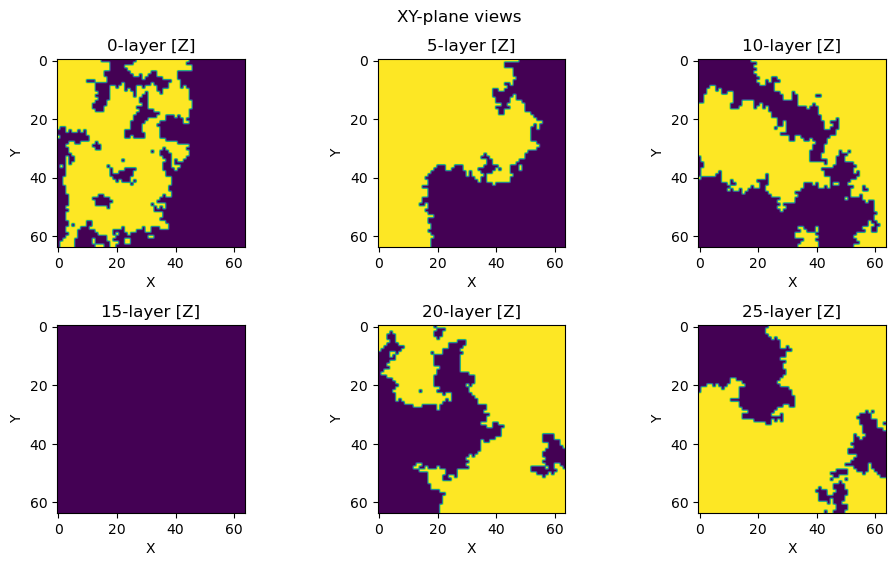

In [65]:
## quick check (couple of quick CS viewws)
plt.figure(figsize = (10,8,))
plt.suptitle('XY-plane views')
for i, layer in enumerate([0,5,10,15,20,25]):
    plt.subplot(3,3,i+1)
    plt.imshow(sis[0,layer])
    plt.title(f'{layer}-layer [Z]')
    plt.xlabel('X')
    plt.ylabel('Y')
plt.tight_layout()

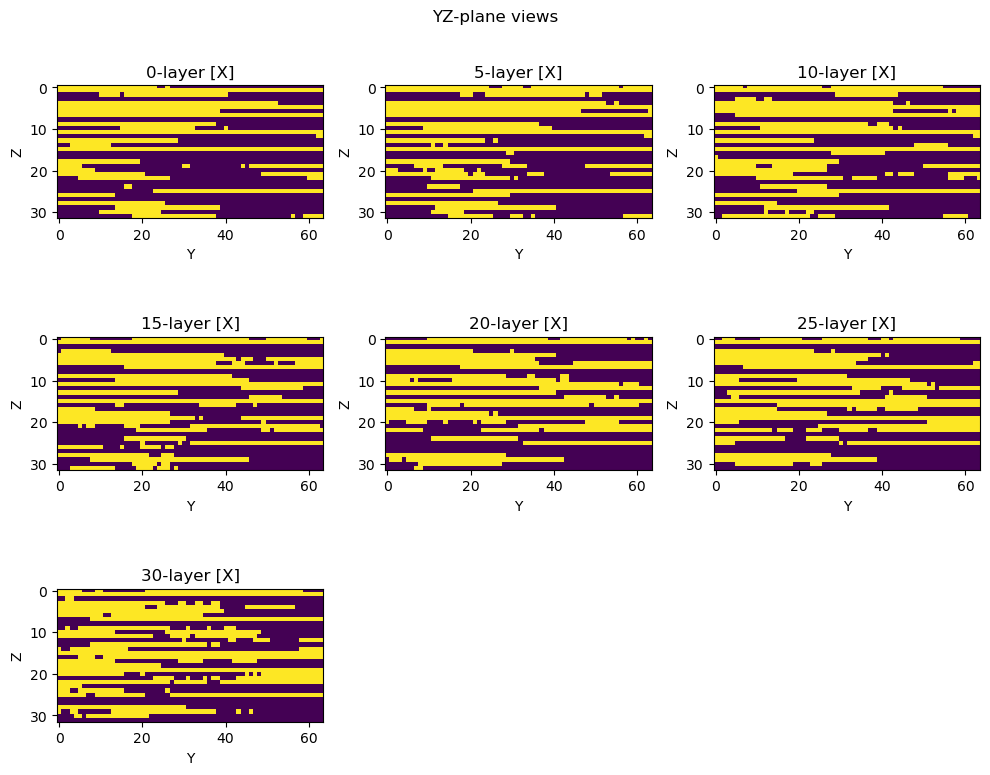

In [66]:
## quick check (couple of quick CS viewws)
plt.figure(figsize = (10,8,))
plt.suptitle('YZ-plane views')
for i, layer in enumerate([0,5,10,15,20,25,30]):
    plt.subplot(3,3,i+1)
    plt.imshow(sis[0,:, :, layer])
    plt.title(f'{layer}-layer [X]')
    plt.xlabel('Y')
    plt.ylabel('Z')
plt.tight_layout()

In [69]:
import matplotlib.cm as cm
from mpl_toolkits import mplot3d
from mpl_toolkits.mplot3d import Axes3D
def visualize_3D_full(cube, nx,ny,nz,angle=320, cmap_ = cm.afmhot):

    cube = (cube-cube.min())/(cube.max()-cube.min())
    facecolors = cmap_(cube)
    facecolors[:,:,:,-1] = 1
    facecolors = explode(facecolors)

    filled = facecolors[:,:,:,-1] != 0
    x, y, z = expand_coordinates(np.indices(np.array(filled.shape) + 1))

    fig = plt.figure(figsize=(15,7))
    ax = plt.subplot(projection='3d')
    ax.view_init(30, angle)
    ax.set_xlim(right=nx*2)
    ax.set_ylim(top=ny*2)
    ax.set_zlim(top=nz*2)      
    im = ax.voxels(x, y, z, filled, facecolors=facecolors)

    ax.set_xlabel("X-axis, grid")
    ax.set_ylabel("Y-axis, grid")
    ax.set_zlabel("Z-axis, grid")
    ax.xaxis.set_pane_color([1.0,1.0,1.0,1.0])    # fig.colorbar(im, ax=ax)
    ax.yaxis.set_pane_color([1.0,1.0,1.0,1.0])    # fig.colorbar(im, ax=ax)
    ax.zaxis.set_pane_color([1.0,1.0,1.0,1.0])    # fig.colorbar(im, ax=ax)
    
    ax.xaxis._axinfo["grid"]['color'] =  (1,1,1,1)
    ax.yaxis._axinfo["grid"]['color'] =  (1,1,1,1)
    ax.zaxis._axinfo["grid"]['color'] =  (1,1,1,1)
def visualize_3D_fence_diagram(cube, nx,ny,nz,angle=320, cmap_ = cm.afmhot):

    cube = (cube-cube.min())/(cube.max()-cube.min())
    facecolors = cmap_(cube)
    fc = np.zeros((nx,ny,nz))
    fc[:,-3,:] = 1
    fc[3,:,:] = 1
    fc[:,:,3] = 1
    facecolors[:,:,:,-1] = 1
    facecolors = explode(facecolors)

    filled = facecolors[:,:,:,-1] != 0
    x, y, z = expand_coordinates(np.indices(np.array(filled.shape) + 1))

    fig = plt.figure(figsize=(15,7))
    ax = plt.subplot(projection='3d')
    ax.view_init(30, angle)
    ax.set_xlim(right=nx*2)
    ax.set_ylim(top=ny*2)
    ax.set_zlim(top=nz*2)      
    im = ax.voxels(x, y, z, filled, facecolors=facecolors)

    ax.set_xlabel("X-axis, grid")
    ax.set_ylabel("Y-axis, grid")
    ax.set_zlabel("Z-axis, grid")
    ax.xaxis.set_pane_color([1.0,1.0,1.0,1.0])    # fig.colorbar(im, ax=ax)
    ax.yaxis.set_pane_color([1.0,1.0,1.0,1.0])    # fig.colorbar(im, ax=ax)
    ax.zaxis.set_pane_color([1.0,1.0,1.0,1.0])    # fig.colorbar(im, ax=ax)
    
    ax.xaxis._axinfo["grid"]['color'] =  (1,1,1,1)
    ax.yaxis._axinfo["grid"]['color'] =  (1,1,1,1)
    ax.zaxis._axinfo["grid"]['color'] =  (1,1,1,1)
def explode(data):
    shape_arr = np.array(data.shape)
    size = shape_arr[:3]*2 - 1
    exploded = np.zeros(np.concatenate([size, shape_arr[3:]]), dtype=data.dtype)
    exploded[::2, ::2, ::2] = data
    return exploded

def expand_coordinates(indices):
    x, y, z = indices
    x[1::2, :, :] += 1
    y[:, 1::2, :] += 1
    z[:, :, 1::2] += 1
    return x, y, z         

In [ ]:
visualize_3D_fence_diagram(sis[0],nx,ny,nz )

I hope you find this code and demonstration useful. I'm always happy to discuss any question you may find,

*Honggeun (honggeun.jo@inha.ac.kr)* 

**Honggeun Jo**, Ph.D., P.Eng. Assistant Professor The Department of Energy Resources Engineering, Inha University (Korea).
